# Loading datasets

In [1]:
import wasmshield.utils, wasmshield.plotting
train_set, test_set, wasm_bench_train_set, wasm_bench_test_set, obfuscated_train_set, obfuscated_test_set, msr_train_set, msr_test_set, llvm_obf_train, llvm_obf_test = wasmshield.utils.load_datasets()

100%|██████████| 3715/3715 [00:00<00:00, 15593.05it/s]


# Choosing random files

In [2]:
import random
import matplotlib.pyplot as plt

files_dict = {
    'taille<1KB': ([], 0, 10**3),
    '1KB<=taille<100KB': ([], 10**3, 10**5),
    '100KB<=taille<1MB': ([], 10**5, 10**6),
    '1MB<=taille<10MB': ([], 10**6, 10**7),
    '10MB<=taille<100MB': ([], 10**7, 10**8),
}
files_names_list = list(set(wasm_bench_train_set+msr_test_set+msr_train_set+msr_test_set))
nb_files_to_get = 500
wasmshield.utils.fill_files_for_sizes(files_names_list, nb_files_to_get, files_dict)

# Loading models

In [3]:
import keras

from gensim.models import Doc2Vec
from wasmshield.models.resbin import (
    build_resbin_8,
    build_resbin_8_sa, 
    build_resbin_18, 
    build_resbin_18_sa
)

doc2vec = Doc2Vec.load('models/doc2vec_mal.model')
minos_model = keras.models.load_model('wasmshield/approaches/original23.h5')

/opt/homebrew/Caskroom/miniforge/base/envs/datascience/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-05-10 21:23:09.389119: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-10 21:23:09.389775: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [74]:
import wasmshield.models
import wasmshield.models.resbin
import wasmshield.approaches
import wasmshield.approaches.jabberwock
import wasmshield.approaches.minos

trainable_models = [
    (
        'ResBin8', 
        lambda:wasmshield.models.resbin.ResBinHandler(build_resbin_8())
    ),
    (
        'ResBin8-SA', 
        lambda:wasmshield.models.resbin.ResBinHandler(build_resbin_8_sa())
    ),
    (
        'ResBin18', 
        lambda:wasmshield.models.resbin.ResBinHandler(build_resbin_18())
    ),
    (
        'ResBin18-SA', 
        lambda:wasmshield.models.resbin.ResBinHandler(build_resbin_18_sa())
    ),
]

models = []
models.extend([
    (
        model_name,
        model_handler
    )
    for model_name, model_handler in trainable_models
])
models.append(
    ('JabberWock', lambda:wasmshield.approaches.jabberwock.JabberWockHandler(
        doc2vec, 
        save_vectors_in="/Volumes/Walid-SSD/ESI/PFE/DATASETS/jabberwock_mal_vectors_128/",
    ))
)
models.append(
    ('MINOS', lambda:wasmshield.approaches.minos.MinosHandler(minos_model))
)


# Evaluation

In [75]:
records = []

In [76]:
from time import perf_counter
import tqdm
from wasmshield.models.base_handler import BaseHandler

def evaluate_time(models:list, files_dict:dict, records:list):
    for model_name, model_handler_loader in models:

        model_handler: BaseHandler = model_handler_loader()

        for file_size, (file_list, *_) in files_dict.items():

            for idx, file in tqdm.tqdm(enumerate(file_list), total=len(file_list)):

                read_time = perf_counter()
                f = open(file,'rb')
                bytes = f.read()
                f.close()
                read_time = perf_counter() - read_time

                preprocess_time = perf_counter()
                i = model_handler.preprocess_bytes(bytes)
                preprocess_time = perf_counter() - preprocess_time

                forward_time = perf_counter()
                v = model_handler.get_vector_from_preprocessed_file(i)
                forward_time = perf_counter() - forward_time

                if idx<=50:
                    continue

                records.append({
                    'model_name' : model_name,
                    'preprocess_time' : preprocess_time,
                    'forward_time' : forward_time,
                    'read_time' : read_time,
                    'time' : read_time+preprocess_time+forward_time,
                    'file_size' : file_size,
                })
        
        del model_handler.model
        del model_handler
    
    return records

evaluate_time(models, files_dict, records)

100%|██████████| 500/500 [00:17<00:00, 28.49it/s]


[{'model_name': 'ResBin8',
  'preprocess_time': 0.00015466699915123172,
  'forward_time': 0.005432250000012573,
  'read_time': 0.00016112500088638626,
  'time': 0.005748042000050191,
  'file_size': 'taille<1KB'},
 {'model_name': 'ResBin8',
  'preprocess_time': 0.0001695420032774564,
  'forward_time': 0.005028667001170106,
  'read_time': 0.0011126249992230441,
  'time': 0.006310834003670607,
  'file_size': 'taille<1KB'},
 {'model_name': 'ResBin8',
  'preprocess_time': 0.00014995899982750416,
  'forward_time': 0.0052779159996134695,
  'read_time': 0.0004116669988434296,
  'time': 0.005839541998284403,
  'file_size': 'taille<1KB'},
 {'model_name': 'ResBin8',
  'preprocess_time': 0.000158582999574719,
  'forward_time': 0.005880459000763949,
  'read_time': 0.0002690410001378041,
  'time': 0.006308083000476472,
  'file_size': 'taille<1KB'},
 {'model_name': 'ResBin8',
  'preprocess_time': 0.0002282919995195698,
  'forward_time': 0.004991999998310348,
  'read_time': 0.00020570800188579597,
  '

In [77]:
import seaborn as sns
import pandas as pd

plot_df = pd.DataFrame.from_records(records)

plot_df['time_ms'] = plot_df['time']*1000
plot_df['forward_time_ms'] = plot_df['forward_time']*1000
plot_df['preprocess_time_ms'] = plot_df['preprocess_time']*1000
plot_df['read_time_ms'] = plot_df['read_time']*1000

colors = [
  '#fdcc8a','#fc8d59','#ff6361','#d7301f',
  '#ffa600',
  '#00c6ff',
    'blue', 'lightblue', 'red']
palette = sns.color_palette(
  colors
)

In [120]:
import matplotlib.pyplot as plt 
import matplotlib.patheffects as pe
plt.style.use('default')
plt.rcParams["axes.grid"] = True

def plot_all_time(plot_df:pd.DataFrame, ylabel, xlabel, legend, group_size):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18,6), facecolor='white')
    ax = axes
    plot_df_cp = plot_df.copy()
    plot_df_cp['file_size'] = plot_df_cp['file_size'].apply(func=lambda x:x.replace('taille', group_size))
    g = sns.barplot(
        plot_df_cp, 
        x='file_size', 
        y='time_ms', 
        hue='model_name', 
        palette=palette, 
        width=0.95,
        ax=ax,
        edgecolor="black",
        saturation=1,
    )

    plt.ylabel(ylabel, fontsize=16)
    plt.xlabel(xlabel, fontsize=16)
    plt.legend(title=legend, fontsize=16)
    g.tick_params(axis='x', labelsize=16)
    g.tick_params(axis='y', labelsize=16)
    plt.yscale('log')

    _patterns = [  "|" , "O", "\\" , '*' , 'x', ".", "-", "/", "+" ,]
    patterns = []
    nb_file_sizes = len(plot_df_cp['file_size'].unique())
    for _pat in _patterns:
        patterns += ([_pat]*nb_file_sizes)
        
    for idx, i in enumerate(g.containers):
        g.bar_label(i, fmt='%.1f', rotation=0, padding=2 if idx%2==0 else 8, path_effects=[pe.withStroke(linewidth=3, foreground="white"), ], weight='bold', fontsize=14)
    for idx, i in enumerate(g.patches):
        i.set_hatch(patterns[idx%len(patterns)])
    ax.legend(fontsize=16)

    plt.show()


# Results

In [121]:
import matplotlib.pyplot as plt 

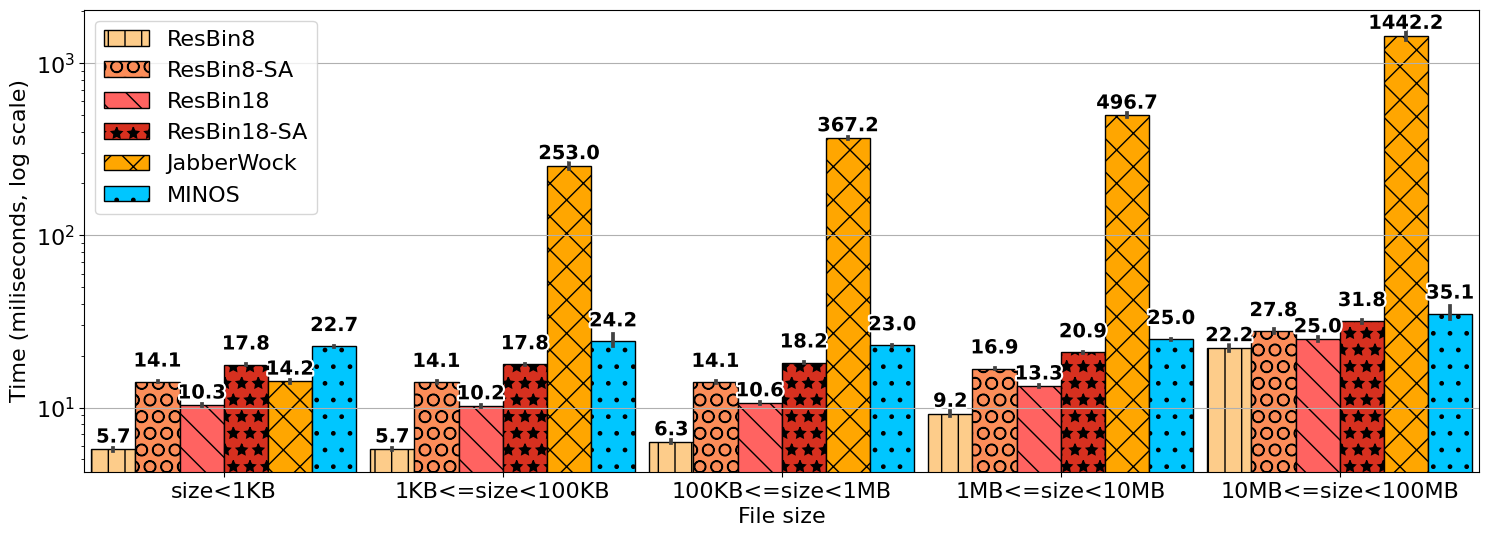

In [123]:
import matplotlib.pyplot as plt 
import matplotlib.patheffects as pe
plt.style.use('default')
plt.rcParams["axes.grid"] = True
plot_all_time(plot_df, ylabel="Time (miliseconds, log scale)", xlabel="File size", legend='Model name', group_size='size')

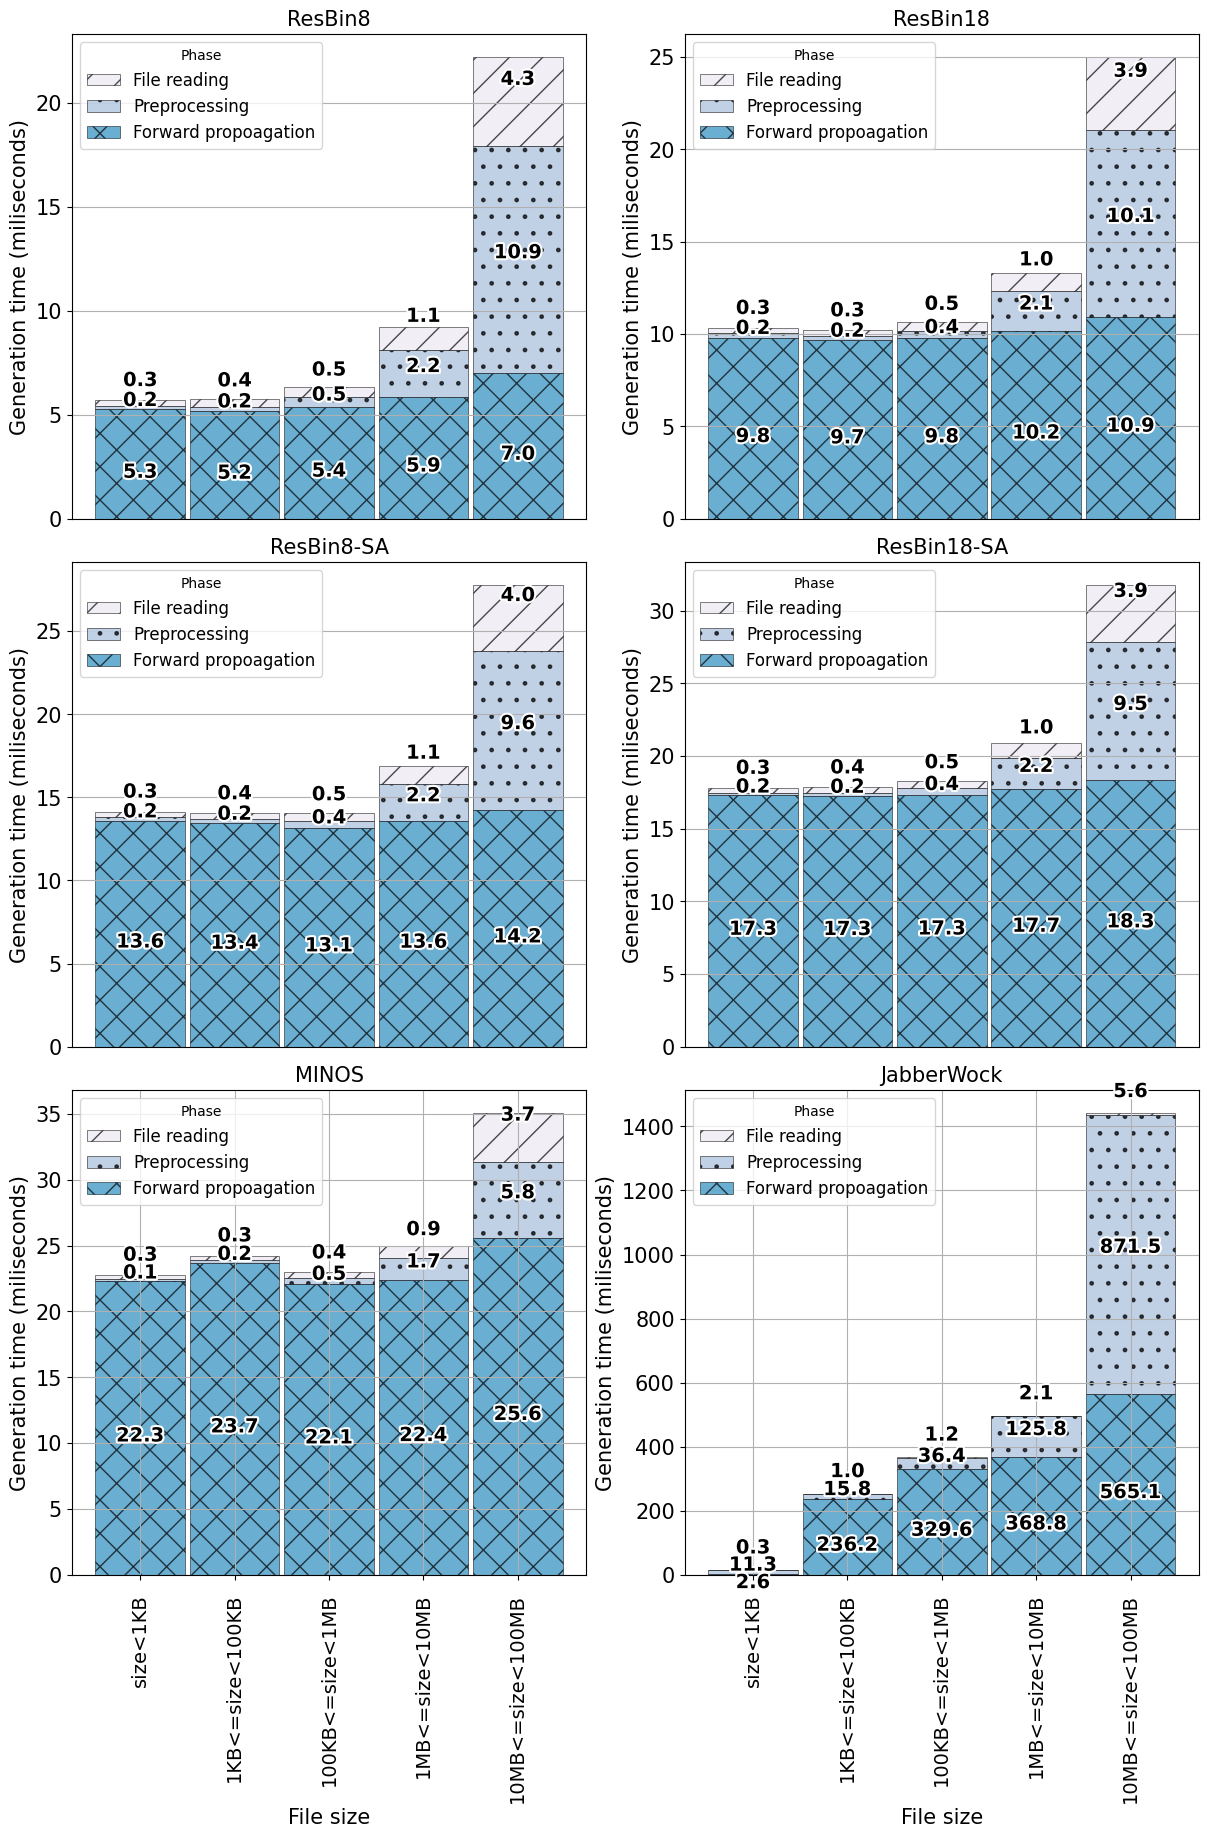

In [125]:
plot_time_hues(
    plot_df,
    labels_mapper={ 'forward_time_ms': 'Forward propoagation','preprocess_time_ms': 'Preprocessing','read_time_ms': 'File reading' },
    ylabel="Generation time (miliseconds)",
    xlabel="File size",
    group_size='size'
)